In [6]:
import sys
import os
import numpy as np
import pandas as pd
import warnings
import plotly
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import plotly.express as px
from pathlib import Path
import warnings
import config
import preprocess

from custom_metrics import LoglossObjective_loop, LoglossObjective_np
from custom_metrics import FocalLossFormulas, AsymmetricLossFormulas
from custom_metrics import AsymmetricLossObjective
from custom_metrics import get_simplified_derivative

from collections import defaultdict
from catboost import CatBoostClassifier, Pool

sys.path.append('./cython_loss')

os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
# import featuretools as ft

warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams["hist.bins"] = 50
print('cur_dir', Path.cwd())

cur_dir /home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/final_project


In [7]:
data = pd.read_csv("/home/sergey/mnt/4.5Tb/Downloads/otus_final_input/data_encoded.csv",
                   low_memory=False,
                   ).astype(config.dtypes)
data = preprocess.preprocess(data)
print("", data.shape)
data.head()

 (274702, 13)


,DealDurationDays,DealDurationMonths,Client_Id,DealDate,ValueDate,MaturityDate,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Deal_characteristics_4,Client_characteristics_1,Client_characteristics_2,target
0,8.0,0,16140,2015-01-12,2015-01-12,2015-01-20,7.018746,0.0000,0.140368,0,15,1759,1
1,53.0,1,21990,2015-01-12,2015-01-12,2015-03-06,0.306237,0.1146,0.087720,2,15,1759,1
2,92.0,3,18607,2015-01-12,2015-01-12,2015-04-14,0.306237,0.1201,0.054139,2,15,1759,1
3,1.0,0,20500,2015-01-12,2015-01-12,2015-01-13,2.985808,0.0896,0.100056,2,15,1759,1
4,1.0,0,4041,2015-01-12,2015-01-12,2015-01-13,0.418013,0.0805,0.168161,2,15,1759,1


In [8]:
# print(data.columns)

In [9]:
X_val = data.groupby(data.Client_Id).tail(1)
y_val = X_val.pop('target')
X_train = data.drop(labels=X_val.index)
y_train = X_train.pop('target')

In [10]:
client_id_activity = X_train.groupby(data.Client_Id).agg(['count', 'mean', 'median'])
print('активность клиентов, простые статистики')
client_id_activity.sort_values(by=('DealDurationDays', 'count'), ascending=False)

активность клиентов, простые статистики


DealDurationDays                   DealDurationMonths            \
                     count       mean median              count      mean   
Client_Id                                                                   
0                    16510  13.290612    7.0              16510  0.245548   
7596                  3353   1.526991    1.0               3353  0.000000   
17708                 2158   1.994903    1.0               2158  0.002780   
8269                  1797   5.678353    6.0               1797  0.000000   
11790                 1439  29.776928   26.0               1439  0.503127   
...                    ...        ...    ...                ...       ...   
1476                     1  28.000000   28.0                  1  0.000000   
10884                    1   7.000000    7.0                  1  0.000000   
1462                     1   3.000000    3.0                  1  0.000000   
5381                     1  13.000000   13.0                  1  0.000000   
6840                     1  33.000000   33.0                  1  1.000000   

                 Client_Id               Deal_characteristics_1  ...  \
          median     count   mean median                  count  ...   
Client_Id                                                        ...   
0            0.0     16510      0      0                  16510  ...   
7596         0.0      3353   7596   7596                   3353  ...   
17708        0.0      2158  17708  17708                   2158  ...   
8269         0.0      1797   8269   8269                   1797  ...   
11790        0.0      1439  11790  11790                   1439  ...   
...          ...       ...    ...    ...                    ...  ...   
1476         0.0         1   1476   1476                      1  ...   
10884        0.0         1  10884  10884                      1  ...   
1462         0.0         1   1462   1462                      1  ...   
5381         0.0         1   5381   5381                      1  ...   
6840         1.0         1   6840   6840                      1  ...   

          Deal_characteristics_3 Deal_characteristics_4                   \
                          median                  count      mean median   
Client_Id                                                                  
0                       0.074074                  16510  1.677832      2   
7596                    0.067925                   3353  2.000000      2   
17708                   0.076577                   2158  1.000000      1   
8269                    0.080000                   1797  0.000000      0   
11790                   0.079261                   1439  0.000000      0   
...                          ...                    ...       ...    ...   
1476                    0.127649                      1  0.000000      0   
10884                   0.109683                      1  2.000000      2   
1462                    0.120395                      1  2.000000      2   
5381                    0.078762                      1  2.000000      2   
6840                    0.086843                      1  2.000000      2   

          Client_characteristics_1                   Client_characteristics_2  \
                             count       mean median                    count   
Client_Id                                                                       
0                            16510  10.497638   13.0                    16510   
7596                          3353   7.232627    7.0                     3353   
17708                         2158  15.000000   15.0                     2158   
8269                          1797  10.648303   15.0                     1797   
11790                         1439  10.970813   15.0                     1439   
...                            ...        ...    ...                      ...   
1476                             1  15.000000   15.0                        1   
10884                            1  15.000000  

In [11]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    X_train = X_train.merge(client_id_activity, how='left', left_on='Client_Id', right_index=True).dropna()
    X_val = X_val.merge(client_id_activity, how='left', left_on='Client_Id', right_index=True)  # .dropna()
# y_val = y_val[X_val.index]

In [12]:
print('data.shape', data.shape)
print('X_train.shape', X_train.shape)
print('X_val.shape', X_val.shape)
print('data.shape[0] - X_val.shape[0] = ', data.shape[0] - X_val.shape[0])
print('data.shape[0] -  X_train.shape[0] - X_val.shape[0] = ', data.shape[0] - X_train.shape[0] - X_val.shape[0])
print(X_train.Client_Id.nunique(), X_val.Client_Id.nunique(), X_train.Client_Id.nunique() - X_val.Client_Id.nunique())

data.shape (274702, 13)
X_train.shape (257180, 39)
X_val.shape (17522, 39)
data.shape[0] - X_val.shape[0] =  257180
data.shape[0] -  X_train.shape[0] - X_val.shape[0] =  0
13050 17522 -4472


In [13]:
train_pool = Pool(data=X_train, label=y_train,
                  cat_features=config.categorical_dtypes_ft.keys())
val_pool = Pool(data=X_val, label=y_val,
                cat_features=config.categorical_dtypes_ft.keys())

## родная Logloss, catboost

In [14]:
%%time

iterations = 50
params = config.params
params.update({
    'loss_function': 'Logloss',
    'iterations': iterations,
    'verbose': iterations // 5,
})
clf_ref_logloss = CatBoostClassifier(**params)
clf_ref_logloss.fit(X=train_pool,
        eval_set=val_pool,
        use_best_model=True)


0:	learn: 0.7196265	test: 0.6101332	best: 0.6101332 (0)	total: 238ms	remaining: 11.7s
10:	learn: 0.7251849	test: 0.6145384	best: 0.6145384 (8)	total: 2.08s	remaining: 7.37s
20:	learn: 0.7257784	test: 0.6147456	best: 0.6147749 (19)	total: 4.15s	remaining: 5.73s
30:	learn: 0.7257723	test: 0.6147456	best: 0.6147749 (19)	total: 6.06s	remaining: 3.71s
40:	learn: 0.7260305	test: 0.6151570	best: 0.6151570 (39)	total: 8.02s	remaining: 1.76s
49:	learn: 0.7260443	test: 0.6151570	best: 0.6155390 (42)	total: 9.63s	remaining: 0us

bestTest = 0.6155390433
bestIteration = 42

Shrink model to first 43 iterations.
CPU times: user 30.5 s, sys: 2.01 s, total: 32.5 s
Wall time: 10.3 s


## внешняя реализация Logloss, numpy, catboost

    Функция потерь logloss реализована через numpy, 
    работает экспоненцильано медленнее, чем родная от catboost
    на 20 итерациях раз в 5 медленнее, на 200 - в 400 раз медленнее
    но намного быстрее, чем если делать с циклом внутри 
    также сходится медленнее, чем родная. Сходимость одинаковая с реализацией через цикл 
    о сходимости есть топик на stackoverflow здесь 

        [](https://stackoverflow.com/questions/63104119/catboost-custom-loss-function)
        


In [15]:
%%time
params = config.params
params.update({
    'loss_function': LoglossObjective_np(),
    'iterations': iterations,
    'verbose': iterations // 5,
})
clf_custom_logloss_np = CatBoostClassifier(**params)

clf_custom_logloss_np.fit(X=train_pool,
        eval_set=val_pool,
        use_best_model=True)


0:	learn: 0.7196265	test: 0.6101332	best: 0.6101332 (0)	total: 1.84s	remaining: 1m 30s
10:	learn: 0.7252499	test: 0.6145677	best: 0.6145677 (9)	total: 21.6s	remaining: 1m 16s
20:	learn: 0.7253582	test: 0.6145872	best: 0.6145872 (16)	total: 40.6s	remaining: 56s
30:	learn: 0.7258230	test: 0.6147771	best: 0.6147771 (25)	total: 1m	remaining: 36.8s
40:	learn: 0.7259405	test: 0.6149471	best: 0.6149471 (39)	total: 1m 19s	remaining: 17.5s
49:	learn: 0.7294851	test: 0.6185626	best: 0.6185633 (48)	total: 1m 35s	remaining: 0us

bestTest = 0.6185632879
bestIteration = 48

Shrink model to first 49 iterations.
CPU times: user 1min 59s, sys: 10.7 s, total: 2min 9s
Wall time: 1min 36s


## внешняя реализация Logloss, простой Python цикл,  catboost

    Здесь функция потерь logloss реализована через цикл, очень медленно выполняется,
    примерно в 8 раз медленнее, чем если реализовать через numpy 
    и в 30 раз медленнее, чем референсная, родная catboost 
    также сходится медленнее, чем родная. Сходимость одинаковая с реализацией через numpy 

    Результаты обоих внешних реализаций LogLoss эквивалентны

In [16]:
%%time
params = config.params
params.update({
    'loss_function': LoglossObjective_loop(),
    'iterations': 2,
    'verbose': 4,
})
clf_logloss_custom_loop = CatBoostClassifier(**params)

clf_logloss_custom_loop.fit(X=train_pool,
        eval_set=val_pool,
        use_best_model=True)



0:	learn: 0.7196265	test: 0.6101332	best: 0.6101332 (0)	total: 6.45s	remaining: 6.45s
1:	learn: 0.7196265	test: 0.6101332	best: 0.6101332 (0)	total: 13.2s	remaining: 0us

bestTest = 0.6101332138
bestIteration = 0

Shrink model to first 1 iterations.
CPU times: user 15.5 s, sys: 1.77 s, total: 17.3 s
Wall time: 13.7 s


## внешняя реализация FocalLoss,
Python, Numpy, первая и вторая производные получены в sympy,  catboost

    Формулы функции потерь обозначены L
    первая и вторая производные der1 и der2
    
    FocalLoss это частный случай AsymmetricLoss,
    когда в формуле ниже gamma_minus == gamma_plus

In [17]:

# Focal_der1, Focal_der2 = FocalLossFormulas()

##
## внешняя реализация AsymmetricLoss, ASL
Python, Numpy, первая и вторая производные получены в sympy,  catboost

    Формулы функции потерь обозначены L
    первая и вторая производные der1 и der2

In [18]:
ASL_der1, ASL_der2 = AsymmetricLossFormulas()

Eq(p, exp(x)/(exp(x) + 1))

Eq(L_plus, (1 - exp(x)/(exp(x) + 1))**g_plus*log(exp(x)/(exp(x) + 1)))

Eq(L_minus, (exp(x)/(exp(x) + 1))**g_minus*log(1 - exp(x)/(exp(x) + 1)))

Eq(L, -y*(1 - exp(x)/(exp(x) + 1))**g_plus*log(exp(x)/(exp(x) + 1)) - (exp(x)/(exp(x) + 1))**g_minus*(1 - y)*log(1 - exp(x)/(exp(x) + 1)))

Eq(L__der1, -g_minus*(exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)*(exp(x) + 1)*exp(-x)*log(1 - exp(x)/(exp(x) + 1)) - g_plus*y*(1 - exp(x)/(exp(x) + 1))**g_plus*(-exp(x)/(exp(x) + 1) + exp(2*x)/(exp(x) + 1)**2)*log(exp(x)/(exp(x) + 1))/(1 - exp(x)/(exp(x) + 1)) - y*(1 - exp(x)/(exp(x) + 1))**g_plus*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)*(exp(x) + 1)*exp(-x) - (exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(-exp(x)/(exp(x) + 1) + exp(2*x)/(exp(x) + 1)**2)/(1 - exp(x)/(exp(x) + 1)))

Eq(L__der2, -g_minus**2*(exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)**2*(exp(x) + 1)**2*exp(-2*x)*log(1 - exp(x)/(exp(x) + 1)) + g_minus*(exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)*(exp(x) + 1)*exp(-x)*log(1 - exp(x)/(exp(x) + 1)) - g_minus*(exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)*log(1 - exp(x)/(exp(x) + 1)) - g_minus*(exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(exp(x) + 1)*(exp(x)/(exp(x) + 1) - 3*exp(2*x)/(exp(x) + 1)**2 + 2*exp(3*x)/(exp(x) + 1)**3)*exp(-x)*log(1 - exp(x)/(exp(x) + 1)) - 2*g_minus*(exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(-exp(x)/(exp(x) + 1) + exp(2*x)/(exp(x) + 1)**2)*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)*(exp(x) + 1)*exp(-x)/(1 - exp(x)/(exp(x) + 1)) - g_plus**2*y*(1 - exp(x)/(exp(x) + 1))**g_plus*(-exp(x)/(exp(x) + 1) + exp(2*x)/(exp(x) + 1)**2)**2*log(exp(x)/(exp(x) + 1))/(1 - exp(x)/(exp(x) + 1))**2 - 2*g_plus*y*(1 - exp(x)

## Упрощенная производная асимметричной функции потерь ASL
      упрощение удаляет все экспоненты, оставляет только логарифмы
      вторая производная намного длиннее, здесь я её не печатаю

In [19]:
ASL_der1_simplified = get_simplified_derivative(ASL_der1, verbose=True, der_name='ASL_der1')
ASL_der2_simplified = get_simplified_derivative(ASL_der2, verbose=False, der_name='ASL_der2')

'Входящая функция производной'

Eq(ASL_der1, -g_minus*(exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)*(exp(x) + 1)*exp(-x)*log(1 - exp(x)/(exp(x) + 1)) - g_plus*y*(1 - exp(x)/(exp(x) + 1))**g_plus*(-exp(x)/(exp(x) + 1) + exp(2*x)/(exp(x) + 1)**2)*log(exp(x)/(exp(x) + 1))/(1 - exp(x)/(exp(x) + 1)) - y*(1 - exp(x)/(exp(x) + 1))**g_plus*(exp(x)/(exp(x) + 1) - exp(2*x)/(exp(x) + 1)**2)*(exp(x) + 1)*exp(-x) - (exp(x)/(exp(x) + 1))**g_minus*(1 - y)*(-exp(x)/(exp(x) + 1) + exp(2*x)/(exp(x) + 1)**2)/(1 - exp(x)/(exp(x) + 1)))

'*********** der.subs(sp.exp(x) / (1 + sp.exp(x)), p) *************'

Eq(ASL_der1, -g_minus*p**g_minus*(1 - y)*(-p**2 + p)*(exp(x) + 1)*exp(-x)*log(1 - p) - g_plus*y*(1 - p)**g_plus*(p**2 - p)*log(p)/(1 - p) - p**g_minus*(1 - y)*(p**2 - p)/(1 - p) - y*(1 - p)**g_plus*(-p**2 + p)*(exp(x) + 1)*exp(-x))

'*********** der.subs(sp.exp(x) / (1 + sp.exp(x)), p) *************'

Eq(ASL_der1, -g_minus*p**g_minus*(1 - y)*(-p**2 + p)*(exp(x) + 1)*exp(-x)*log(1 - p) - g_plus*y*(1 - p)**g_plus*(p**2 - p)*log(p)/(1 - p) - p**g_minus*(1 - y)*(p**2 - p)/(1 - p) - y*(1 - p)**g_plus*(-p**2 + p)*(exp(x) + 1)*exp(-x))

'**********    der.subs((1 + sp.exp(x))**2 * sp.exp(x)**(-2), p**(-2))  *****************'

Eq(ASL_der1, -g_minus*p**g_minus*(1 - y)*(-p**2 + p)*(exp(x) + 1)*exp(-x)*log(1 - p) - g_plus*y*(1 - p)**g_plus*(p**2 - p)*log(p)/(1 - p) - p**g_minus*(1 - y)*(p**2 - p)/(1 - p) - y*(1 - p)**g_plus*(-p**2 + p)*(exp(x) + 1)*exp(-x))

'*********** sp.symplify(der) *************'

Eq(ASL_der1, p*((p - 1)*(-g_minus*p**g_minus*(y - 1)*log(1 - p) + y*(1 - p)**g_plus)*(exp(x) + 1) + (g_plus*y*(1 - p)**g_plus*log(p) - p**g_minus*(y - 1))*exp(x))*exp(-x))

'*********** sp.factor(der) *************'

Eq(ASL_der1, p*(-g_minus*p*p**g_minus*y*exp(x)*log(1 - p) - g_minus*p*p**g_minus*y*log(1 - p) + g_minus*p*p**g_minus*exp(x)*log(1 - p) + g_minus*p*p**g_minus*log(1 - p) + g_minus*p**g_minus*y*exp(x)*log(1 - p) + g_minus*p**g_minus*y*log(1 - p) - g_minus*p**g_minus*exp(x)*log(1 - p) - g_minus*p**g_minus*log(1 - p) + g_plus*y*(1 - p)**g_plus*exp(x)*log(p) + p*y*(1 - p)**g_plus*exp(x) + p*y*(1 - p)**g_plus - p**g_minus*y*exp(x) + p**g_minus*exp(x) - y*(1 - p)**g_plus*exp(x) - y*(1 - p)**g_plus)*exp(-x))

'*********** sp.factor(der) *************'

Eq(ASL_der1, p*(-g_minus*p*p**g_minus*y*exp(x)*log(1 - p) - g_minus*p*p**g_minus*y*log(1 - p) + g_minus*p*p**g_minus*exp(x)*log(1 - p) + g_minus*p*p**g_minus*log(1 - p) + g_minus*p**g_minus*y*exp(x)*log(1 - p) + g_minus*p**g_minus*y*log(1 - p) - g_minus*p**g_minus*exp(x)*log(1 - p) - g_minus*p**g_minus*log(1 - p) + g_plus*y*(1 - p)**g_plus*exp(x)*log(p) + p*y*(1 - p)**g_plus*exp(x) + p*y*(1 - p)**g_plus - p**g_minus*y*exp(x) + p**g_minus*exp(x) - y*(1 - p)**g_plus*exp(x) - y*(1 - p)**g_plus)*exp(-x))

'*********** sp.symplify(der) *************'

Eq(ASL_der1, p*(g_minus*p**g_minus*y*exp(x)*log(1 - p) + g_minus*p**g_minus*y*log(1 - p) - g_minus*p**g_minus*exp(x)*log(1 - p) - g_minus*p**g_minus*log(1 - p) - g_minus*p**(g_minus + 1)*y*exp(x)*log(1 - p) - g_minus*p**(g_minus + 1)*y*log(1 - p) + g_minus*p**(g_minus + 1)*exp(x)*log(1 - p) + g_minus*p**(g_minus + 1)*log(1 - p) + g_plus*y*(1 - p)**g_plus*exp(x)*log(p) + p*y*(1 - p)**g_plus*exp(x) + p*y*(1 - p)**g_plus - p**g_minus*y*exp(x) + p**g_minus*exp(x) - y*(1 - p)**g_plus*exp(x) - y*(1 - p)**g_plus)*exp(-x))

'**********    der.subs(sp.exp(x), p / (1-p))  *****************'

Eq(ASL_der1, (1 - p)*(g_minus*p*p**g_minus*y*log(1 - p)/(1 - p) - g_minus*p*p**g_minus*log(1 - p)/(1 - p) - g_minus*p*p**(g_minus + 1)*y*log(1 - p)/(1 - p) + g_minus*p*p**(g_minus + 1)*log(1 - p)/(1 - p) + g_minus*p**g_minus*y*log(1 - p) - g_minus*p**g_minus*log(1 - p) - g_minus*p**(g_minus + 1)*y*log(1 - p) + g_minus*p**(g_minus + 1)*log(1 - p) + g_plus*p*y*(1 - p)**g_plus*log(p)/(1 - p) + p**2*y*(1 - p)**g_plus/(1 - p) - p*p**g_minus*y/(1 - p) + p*p**g_minus/(1 - p) + p*y*(1 - p)**g_plus - p*y*(1 - p)**g_plus/(1 - p) - y*(1 - p)**g_plus))

'*********** sp.factor(der) *************'

Eq(ASL_der1, -g_minus*p*p**g_minus*y*log(1 - p) + g_minus*p*p**g_minus*log(1 - p) + g_minus*p**g_minus*y*log(1 - p) - g_minus*p**g_minus*log(1 - p) + g_plus*p*y*(1 - p)**g_plus*log(p) - p*p**g_minus*y + p*p**g_minus + p*y*(1 - p)**g_plus - y*(1 - p)**g_plus)

'*********** sp.symplify(der) *************'

Eq(ASL_der1, g_minus*p**g_minus*y*log(1 - p) - g_minus*p**g_minus*log(1 - p) - g_minus*p**(g_minus + 1)*y*log(1 - p) + g_minus*p**(g_minus + 1)*log(1 - p) + g_plus*p*y*(1 - p)**g_plus*log(p) + p*y*(1 - p)**g_plus - p**(g_minus + 1)*y + p**(g_minus + 1) - y*(1 - p)**g_plus)

# вычисление модели с асимметричной функцией потерь
### Здесь функция потерь AsymmetricLoss ASL реализована через numpy, Python
      формула приводится выше
      gamma - это гиперпараметры модели, их можно подбирать HyperBand'ом, к примеру
      Здесь я оптимизирую  AUC, метрику F_beta не успел доделать

In [20]:
%%time
params = config.params
params.update({
    'loss_function': AsymmetricLossObjective(der1=ASL_der1_simplified,
                                             der2=ASL_der2_simplified,
                                             gamma_minus=0.2,
                                             gamma_plus=0.6),
    'iterations': iterations,
    'verbose': iterations // 5,
})
clf_custom_asl = CatBoostClassifier(**params)
clf_custom_asl.fit(X=train_pool,
        eval_set=val_pool,
        use_best_model=True)


0:	learn: 0.7196265	test: 0.6101332	best: 0.6101332 (0)	total: 19.7s	remaining: 16m 7s
10:	learn: 0.7265703	test: 0.6163402	best: 0.6163402 (10)	total: 3m 56s	remaining: 13m 58s
20:	learn: 0.7267891	test: 0.6163860	best: 0.6163860 (20)	total: 7m 4s	remaining: 9m 45s
30:	learn: 0.7272849	test: 0.6172047	best: 0.6172047 (29)	total: 10m 14s	remaining: 6m 16s
40:	learn: 0.7271928	test: 0.6172308	best: 0.6172308 (33)	total: 14m 12s	remaining: 3m 7s
49:	learn: 0.7291334	test: 0.6178568	best: 0.6180609 (44)	total: 17m 58s	remaining: 0us

bestTest = 0.6180609122
bestIteration = 44

Shrink model to first 45 iterations.
CPU times: user 19min 29s, sys: 1min 50s, total: 21min 19s
Wall time: 17min 59s


## Здесь функция потерь FocalLoss реализована через numpy, Python как частный случай ASL

      FocalLoss это частный случай AsymmetricLoss ASL,
      когда в формуле аргумент gamma_minus == gamma_plus

            формула приводится выше
      gamma - это гиперпараметры модели, их можно подбирать HyperBand'ом, к примеру
      Здесь я оптимизирую AUC



In [21]:
%%time
params = config.params
params.update({
    'loss_function': AsymmetricLossObjective(der1=ASL_der1_simplified,
                                             der2=ASL_der2_simplified,
                                             gamma_minus=0.5,
                                             gamma_plus=0.5),
    'iterations': iterations,
    'verbose': iterations // 5,
})
clf_custom_focalloss = CatBoostClassifier(**params)
clf_custom_focalloss.fit(X=train_pool,
        eval_set=val_pool,
        use_best_model=True)


0:	learn: 0.7196265	test: 0.6101332	best: 0.6101332 (0)	total: 23.3s	remaining: 19m 2s
10:	learn: 0.7252499	test: 0.6145677	best: 0.6145677 (9)	total: 4m 20s	remaining: 15m 22s
20:	learn: 0.7253582	test: 0.6145872	best: 0.6145872 (16)	total: 8m 3s	remaining: 11m 7s
30:	learn: 0.7258230	test: 0.6147771	best: 0.6147771 (25)	total: 11m 43s	remaining: 7m 11s
40:	learn: 0.7259405	test: 0.6149471	best: 0.6149471 (39)	total: 15m 39s	remaining: 3m 26s
49:	learn: 0.7294851	test: 0.6185626	best: 0.6185633 (48)	total: 19m 14s	remaining: 0us

bestTest = 0.6185632879
bestIteration = 48

Shrink model to first 49 iterations.
CPU times: user 20min 54s, sys: 1min 44s, total: 22min 38s
Wall time: 19min 14s


In [22]:
results = {
    'reference_logloss': clf_ref_logloss.get_evals_result()['validation'],
    'numpy Python': clf_custom_logloss_np.get_evals_result()['validation'],
    'ASL': clf_custom_asl.get_evals_result()['validation'],
    'FocalLoss': clf_custom_focalloss.get_evals_result()['validation'],
}

In [23]:
def plot_result_metric(metric):
    fig = plt.figure()
    plt.title(label=metric)
    ax = fig.add_subplot(1, 1, 1)
    evals_df = pd.DataFrame()

    for label, evals in results.items():
        evals_df[label] = evals[metric]
        ax.plot(evals[metric], label=label)
    print(evals_df.tail())

    plt.xlabel('iterations')
    plt.ylabel(f'{metric} score')
    plt.legend()
    plt.show();

<ipython-input-23-2c34a31e4acb>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


    reference_logloss  numpy Python       ASL  FocalLoss
45           0.615157      0.618143  0.618061   0.618143
46           0.615157      0.618182  0.618046   0.618182
47           0.615157      0.618554  0.617875   0.618554
48           0.615539      0.618563  0.617892   0.618563
49           0.615157      0.618563  0.617857   0.618563


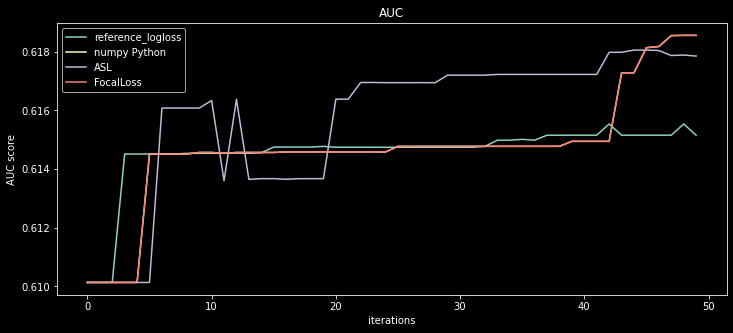

In [24]:
plot_result_metric("AUC")

<ipython-input-23-2c34a31e4acb>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


    reference_logloss  numpy Python       ASL  FocalLoss
45             0.4522      0.452176  0.478336   0.452176
46             0.4522      0.452176  0.478875   0.452176
47             0.4522      0.452176  0.478875   0.452176
48             0.4522      0.452176  0.478875   0.452176
49             0.4522      0.452200  0.478875   0.452200


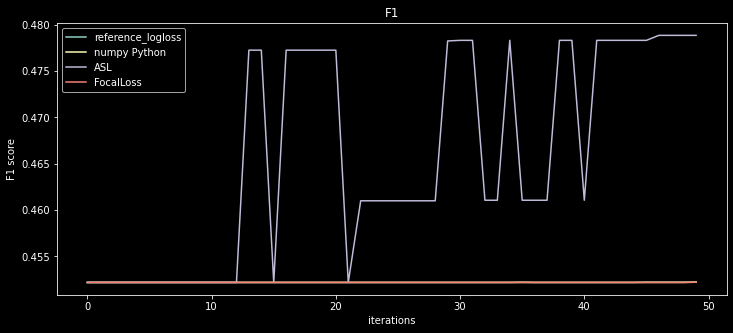

In [25]:
plot_result_metric('F1')

## Ссылки
    [Статья с описанием AsymmetricLoss на arxiv.org](https://arxiv.org/pdf/2009.14119.pdf)



